# Homework 3  - Part B


###### Roll Number: 20100040

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [0]:
!pip install tensorflow-gpu==1.14

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 20100040
np.random.seed(your_id)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip -uq "/content/drive/My Drive/DeepLearning HW_3/cifar.zip" -d "./images"

###### Hyperparameters

In [0]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = './images/cifar/'
epochs = 25
all_histories = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [0]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'
# files = glob('./images/train/**/*.jpgs')
# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
train_files = np.array([f for f in glob.glob(train_dir + "**/*.png", recursive=True)])
test_data = np.array([f for f in glob.glob(test_dir + "**/*png", recursive=True)])


# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
classes = []
with open(label_dir) as f:
  classes = f.read().split()

Labels = {}
for i in range(len(classes)):
    Labels[classes[i]] = i
# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
train_data, val_data = train_test_split(train_files, test_size=0.2, random_state=1)

print(len(train_data), "train samples")
print(len(val_data), "validation samples") 
print(len(test_data), "test samples") 
print(Labels)


40000 train samples
10000 validation samples
10000 test samples
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [0]:
def preprocessing_norm (images):
    images = images.astype('float')
    images /= 255.0
    return images

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [0]:
def preprocessing_meanShift (images):
    images = images.astype('float')
    channels = ['R', 'G', 'B']
    for channel in range(len(channels)):
        mean = np.mean(images[:,:,channel])
        std = np.std(images[:,:,channel])
        images[:,:,channel] = (images[:,:,channel] - mean)/std
    return images

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [0]:
def get_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def extract_label(path):
    return Labels[(path.split('_'))[1].split('.')[0]]

def data_generator( paths , batch_size = 32, preprocessing = None):
    
    start_indices = np.arange(0, len(paths), batch_size)
    if len(paths) % batch_size != 0:
        start_indices = start_indices[:-1]

    while True:
        np.random.shuffle(start_indices)
        for index in start_indices:
            batch_paths = paths[index:index+batch_size]
            X_input = np.array([get_image(path) for path in batch_paths])
            Y_output = np.array([extract_label(path) for path in batch_paths])
            if(preprocessing == 'norm'):
                X_input = preprocessing_norm(X_input)
            elif(preprocessing == 'meanShift'):
                X_input = preprocessing_meanShift(X_input)

            yield X_input, to_categorical(Y_output, num_classes=len(classes), dtype='int')   



### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [0]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=(input_shape_cifar), name='input_img')
hidden1 = Conv2D(32, kernel_size=(3,3), activation='relu', strides=(2,2))(input_img) # extract low level features
hidden2 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(2,2))(hidden1) # extract deeper features
hidden3 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(2,2))(hidden2) # extract deeper features
flatten = Flatten()(hidden3)
output1 = Dense(64, activation='relu')(flatten)
output = Dense(num_classes, activation='softmax')(output1)
model_initial = Model(inputs=input_img, outputs=output)

#### Compile model and plot

In [0]:
model_name = 'base_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
   

In [0]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)

# Use the appropriate loss function and compile the model
model_initial.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

In [0]:
model_initial.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_33 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                36928     
_________________________________________________________________
dense_66 (Dense)             (None, 10)                650

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [0]:
# Create three generators: For training your model, for validation, for testing.
train_initial = data_generator(train_data, batch_size)
val_initial = data_generator(val_data, batch_size)
test_initial = data_generator(test_data, batch_size)


In [0]:
# Start training your model here
hist_initial = model_initial.fit_generator(generator=train_initial, steps_per_epoch=int(len(train_data)/batch_size), 
                                           epochs=epochs, callbacks=callbacks, validation_data=val_initial,
                                           validation_steps = int(len(val_data)/batch_size), validation_freq=1)

all_histories.append(hist_initial)

#### Base Model Analysis ####

The architechture of the base model was inpired by [This article](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7). However several hyperparamets were varied in it's construction

1. Number of filters used: The number of filters varied a lot. I tested out filter numbers of [5, 8, 10, 20, 30, 32 and 64]. During this testing, i found that in a single layered convolution, a small filter size yeilded the best accuracy (~60%)

2. Number of layers used: The motivation behind using multiple convolution layers for the network was to learn several local low level features in early stages, and combine them into complex features in deeper layers. I started out with a combination of 2 layers with 5 x 10 filters, then 8 x 16, 10 x 20, and then 32 x 64. From my testing 10 x 20 gave the best accuracy (~74%). Following this I used a 3 layer network as mentioned in the article with a combination of 32 x 32 x 64 filters. This was a slightly overfitted network as it gave us an accuracy of 90% but the highest validation loss yet. 

3. Strides, kernal size and Padding: Due to the small size of the image, strides and kernal size were kept small and no padding was added as the borders of the images did not contain as much useful information as the centers

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
hidden1 = Conv2D(32, kernel_size=(3,3), activation='relu', strides=(2,2))(input_img) # extract low level features
hidden2 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(2,2))(hidden1) # extract deeper features
hidden3 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(2,2))(hidden2) # extract deeper features
flatten = Flatten()(hidden3)
output1 = Dense(50, activation='relu')(flatten)
output = Dense(num_classes, activation='softmax')(output1)
model_preprocessed = Model(inputs=input_img, outputs=output)

In [0]:
model_name = 'preprocessed_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [0]:
# You may tweak this Learning Rate
adam = Adam(lr=0.001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [0]:
model_preprocessed.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_34 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 50)                28850     
_________________________________________________________________
dense_68 (Dense)             (None, 10)                510

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

In [0]:
# Create three generators again
train_pre_processessed = data_generator(train_data, batch_size, 'norm')
val_pre_processessed = data_generator(val_data, batch_size, 'norm')
test_pre_processessed = data_generator(test_data, batch_size, 'norm')

In [0]:
hist_preprocessed = model_preprocessed.fit_generator(generator=train_pre_processessed, steps_per_epoch=int(len(train_data)/batch_size), 
                                           epochs=epochs, callbacks=callbacks, validation_data=val_pre_processessed,
                                           validation_steps = int(len(val_data)/batch_size), validation_freq=1)
all_histories.append(hist_preprocessed)

#### Preprocessed Analysis ####

When comparing this to the base model, one thing was consistently noted. When the base model was kept simple, i.e no more than 2 layers at 10 x 20 filters, the preprocessed model shot up in accuracy a lot earlier. When the base model hit accuracies around 15% on the first epoch, the preprocessed model hit accuries close to 35% on the first epoch. However, in the overall picture, both models have almost the same accuracy. One thing to be noted is the sharply lower validation loss of the preprocessed model as the normalization of the model serves to reduce overfitting the model

### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_pooling'

input_img = Input(shape=(input_shape_cifar), name='input_img')
hidden1 = Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1,1))(input_img) # extract low level features
pool1 = MaxPooling2D(pool_size=(2, 2))(hidden1) # pool from first convolved set
hidden2 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(pool1) # extract deeper features
pool2 = MaxPooling2D(pool_size=(2, 2))(hidden2) # pool from second convolved 
hidden3 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(pool2) # extract deeper features
flatten = Flatten()(hidden3)
output1 = Dense(64, activation='relu')(flatten)
output = Dense(num_classes, activation='softmax')(output1)
model_pooled = Model(inputs=input_img, outputs=output)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_35 (Flatten)         (None, 1024)              0  

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

In [0]:
# Create generators
train_pool = data_generator(train_data, batch_size)
val_pool = data_generator(val_data, batch_size)
test_pool = data_generator(test_data, batch_size)

In [0]:
hist_pooled = model_pooled.fit_generator(generator=train_pool, steps_per_epoch=int(len(train_data)/batch_size), 
                                           epochs=epochs, callbacks=callbacks, validation_data=val_pool,
                                           validation_steps = int(len(val_data)/batch_size), validation_freq=1)
all_histories.append(hist_pooled)

#### Pooling analysis ####

The pooling model had some changes. Mainly, the number of strides taken by the convolution layers was reduced as the pooling layer was already decreasing the spatial size of the output. The pooling accuracy is also close the base model, with a higher validation accuracy and a lower validaiton loss. Since no preprocessing was used, the validation loss is still higher than the preprocessed model however by reducing the spacial size of the network, less features are being learnt, which counters the overfitted base model hence giving us a higher validation accuracy

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_dropout'

input_img = Input(shape=(input_shape_cifar), name='input_img')
hidden1 = Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1,1))(input_img) # extract low level features
pool1 = MaxPooling2D(pool_size=(2, 2))(hidden1) # pool from first convolved set
dropout1 = Dropout(rate=0.2)(pool1)

hidden2 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(dropout1) # extract deeper features
pool2 = MaxPooling2D(pool_size=(2, 2))(hidden2) # pool from second convolved set
dropout2 = Dropout(rate=0.2)(pool2)

hidden3 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(dropout2)

flatten = Flatten()(hidden3)
output1 = Dense(50, activation='relu')(flatten)

output = Dense(num_classes, activation='softmax')(output1)
model_dropout = Model(inputs=input_img, outputs=output)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_dropout.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
# model_dropout.summary()

In [0]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

In [0]:
# Create three Generators
train_dropout = data_generator(train_data, batch_size)
val_dropout = data_generator(val_data, batch_size)
test_dropout = data_generator(test_data, batch_size)

In [0]:
hist_dropout = model_dropout.fit_generator(generator=train_dropout, steps_per_epoch=int(len(train_data)/batch_size), 
                                           epochs=epochs, callbacks=callbacks, validation_data=val_dropout,
                                           validation_steps = int(len(val_data)/batch_size), validation_freq=1)

all_histories.append(hist_dropout)

#### Dropout Analysis ####
The dropout model serves it's exact purpose; prevent overfitting. It gives us the lowest validation loss so far and the highest validation accuracy. This is because of dropping random connection in the network and making the network less complex. Several parameters were tested for the dropout layers, i.e where to place it, what to choose as the rate, and how many dropout layers to include. I tested with 3 dropout layers placed at different parts but since they were giving a very low accuracy (~10%), i dropped down to 2 dropout layers. They were placed after the Max Pooling layers since they counter the function of the pooling layers which place high dependancy on a small set of features. The dropout value was varied in the list [0.1, 0.2, 0.3, 0.5, 0.7]. With 0.2 giving the best validation loss and accuracy and higher dropout values subsequently performing worse, due to dropping too many features leading to the network not learning correctly.

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [0]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
hidden1 = Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1,1))(input_img) # extract low level features
pool1 = MaxPooling2D(pool_size=(2, 2))(hidden1) # pool from first convolved set
norm1 = BatchNormalization()(pool1)
dropout1 = Dropout(rate=0.2)(norm1)


hidden2 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(dropout1) # extract deeper features
pool2 = MaxPooling2D(pool_size=(2, 2))(hidden2) # pool from second convolved set
norm2 = BatchNormalization()(pool2)
dropout2 = Dropout(rate=0.2)(norm2)

hidden3 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(dropout2)

flatten = Flatten()(hidden3)
output1 = Dense(50, activation='relu')(flatten)

output = Dense(num_classes, activation='softmax')(output1)
model_normalized = Model(inputs=input_img, outputs=output)

In [0]:
adam = Adam(lr=0.001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 6, 6, 64)          0  

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, tensorboard]

In [0]:
# Create three generators
train_norm = data_generator(train_data, batch_size)
val_norm = data_generator(val_data, batch_size)
test_norm = data_generator(test_data, batch_size)

In [0]:
hist_normalized = model_normalized.fit_generator(generator=train_norm, steps_per_epoch=int(len(train_data)/batch_size), 
                                           epochs=epochs, callbacks=callbacks, validation_data=val_norm,
                                           validation_steps = int(len(val_data)/batch_size), validation_freq=1)
all_histories.append(hist_normalized)

#### Batch Normalization Analysis ####
As batch normalization smoothens the gradient descent making the gradient more reliable and predictive, it is no wonder that it also gives us the best validation_loss and accuracy alongside the dropout model. Since there are several layers in this network, I placed the batchNormalization() function after the two series convolution + pooling layers in order to reduce the covariate shift after each section of feature selection. I left it out on the 


### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [0]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

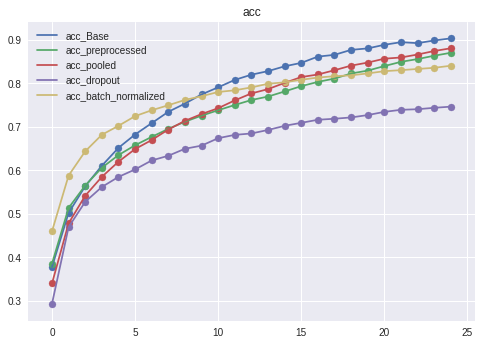

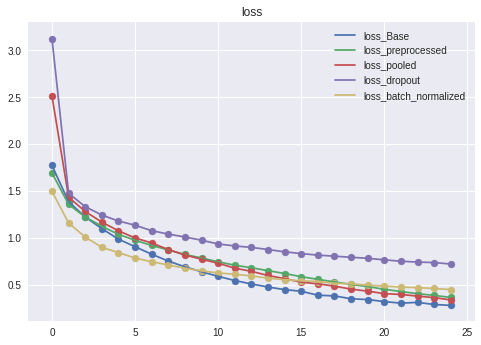

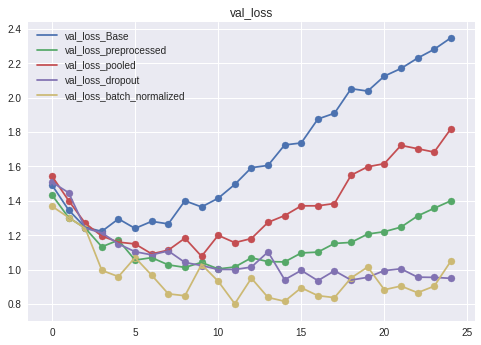

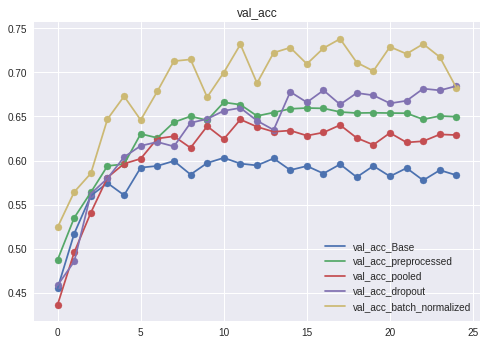

In [0]:
# Plot histories of all models
names = ['Base', 'preprocessed', 'pooled', 'dropout', 'batch_normalized']
plotHistory(all_histories, names, 'acc')
plotHistory(all_histories, names, 'loss')
plotHistory(all_histories, names, 'val_loss')
plotHistory(all_histories, names, 'val_acc')

#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory```

Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir './base_model'

In [0]:
%tensorboard --logdir './preprocessed_model'

In [0]:
%tensorboard --logdir './model_pooling'

In [0]:
%tensorboard --logdir './model_dropout'

In [0]:
%tensorboard --logdir './model_batch_normalized'

### Analysis ### 



*   Starting off, let us compare the accuracy and the loss of all the models. We see that they follow the same order. With the overfitted base model giving the highest accuracy and lowest loss. Following that is the pooling model, which by reducing the spacial size of the network and removing some features, makes the network more true in it's fitting but still giving a high accuracy. The preprocessed and batch normalized model both counter the overfitting by normalizing the model and the lowest accuracy comes from the dropout model which reduces the feature space being learnt by the model, hence reducing accuracy
* The validation accuracy and loss give a more wholistic view which models actually seem to be performing well. Over here, the base model performs the worst since it has been overfit and cannot correctly clasify the newer images. Conversely the dropout model performs the best, alongside the batchNorm model which also makes use of dropouts. These two give the best validation accuracy and loss as they prevent the network from being overfitted.
* The batch normalization model also shows the most variance in it's accuracy as it starts out with the highest first epoch accuracy but fluctuates a lot throughout the training process
* The model chosen by me, as the best one, is the dropout model, as it not only gives the highest validation accuracy but also keeps the validation accuracy very close to the training accuracy.





### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

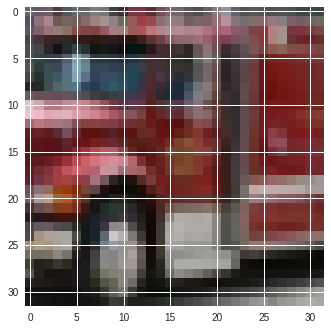

In [0]:
# Load any image here
test_image = get_image('./images/cifar/train/88_truck.png')

plt.imshow(test_image)

array([9])

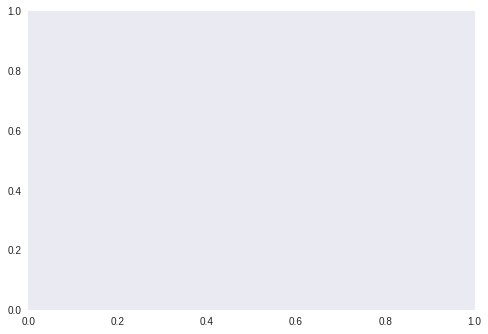

In [0]:
plt.gca().grid(False);

test_reshaped = test_image.reshape((1,32,32,3))

# Get a prediction from ANY ONE of your models and output its label
model_dropout.predict(test_reshaped).argmax(axis=1)

In [0]:
# Create a Model from the Input layer to a Convolutional Layer
new_model = Model(inputs = model_dropout.get_layer('input_img').output,
                  outputs = model_dropout.get_layer('conv2d_97').output)

In [0]:
# Get a prediction for your chosen image using this model
predicted_activations = new_model.predict(test_reshaped)

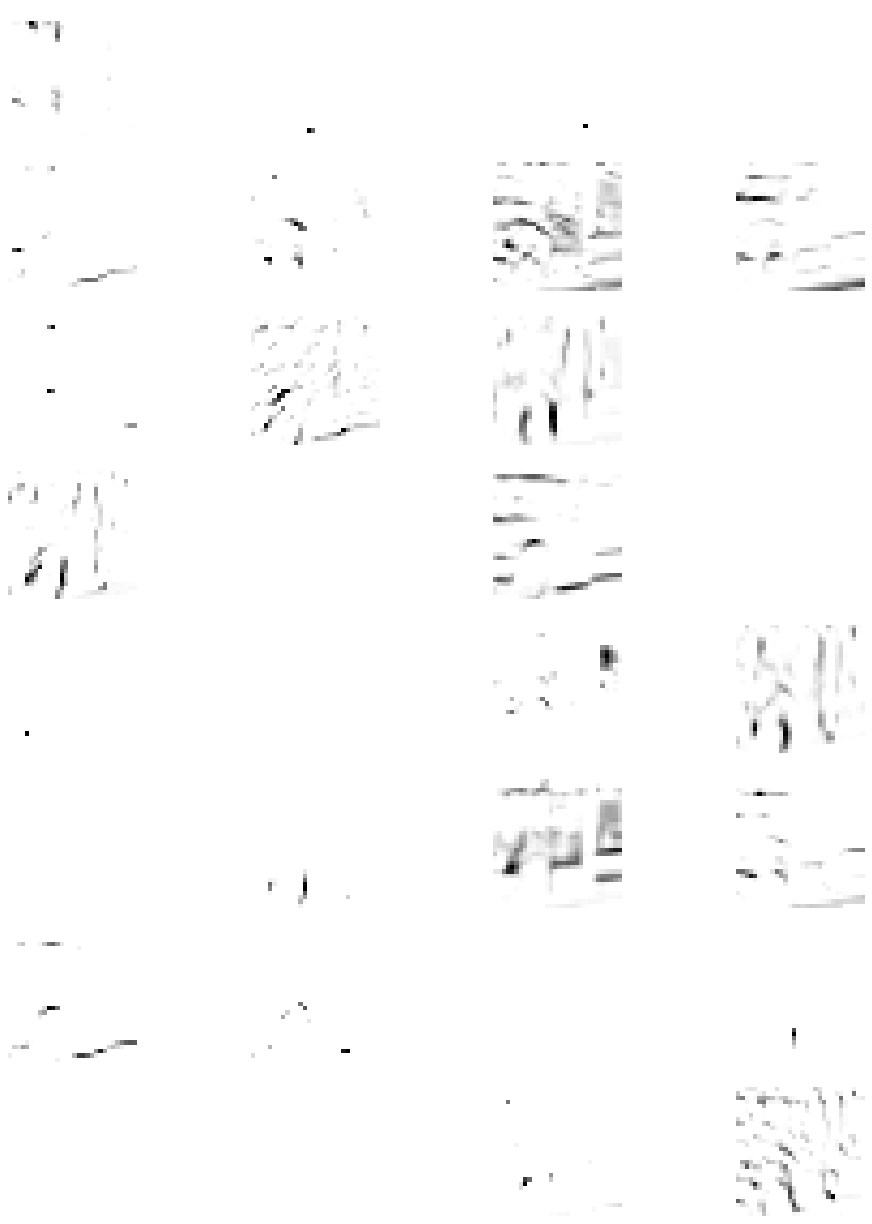

In [0]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [0]:
# Create another model to visualize activations from ANOTHER convolutional layer
second_model = Model(inputs = model_dropout.get_layer('input_img').output,
                  outputs = model_dropout.get_layer('conv2d_98').output)

In [0]:
# You may rename this variable
second_predicted_activations = second_model.predict(test_reshaped)

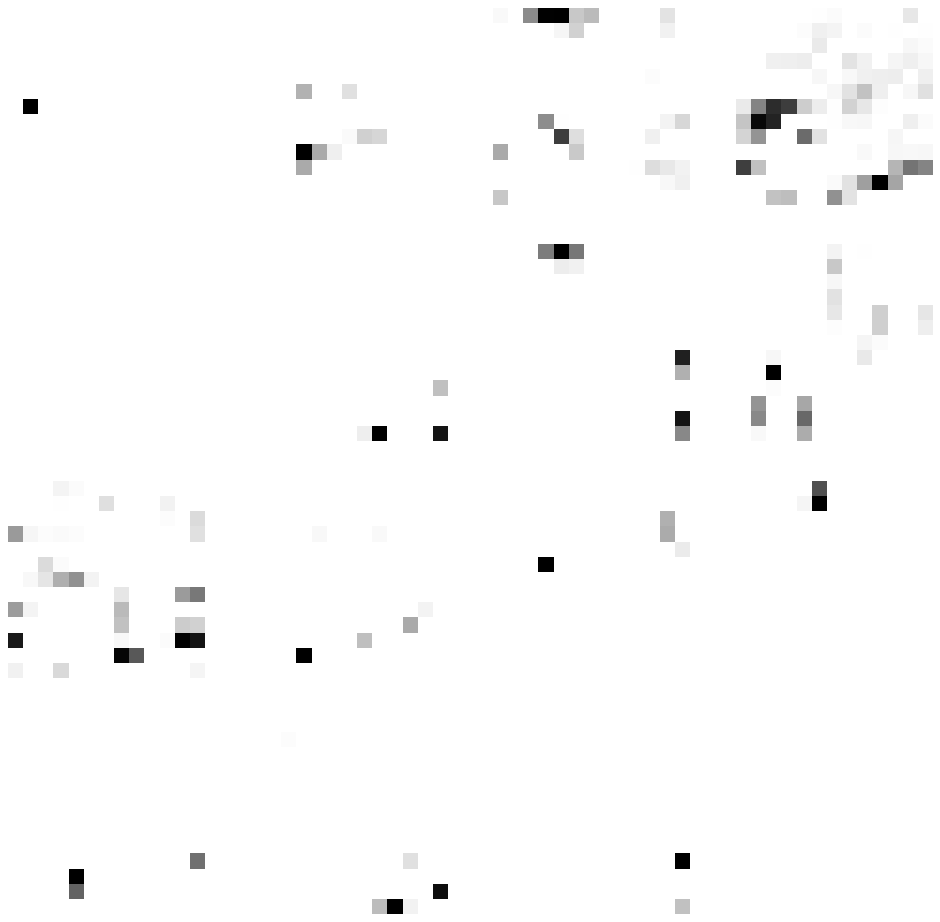

In [0]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?

A) The first convolution layer was able to learn some vertical and horizontal edges. The later convolution layers only identified some pixel patters. As the number of convolution layers increases and the spacial size of the image decreases, the network filters start identifying deeper features of the image. In this case, since the image is so small, the later convolution layers only go on to identify some pixel patterns and look at smaller and smaller spaces.

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [0]:
learning_rate_hist = []

In [0]:
# Use code provided in previous tasks
model_name = 'model_dropout_' + str(0.00001)

input_img = Input(shape=(input_shape_cifar), name='input_img')
hidden1 = Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1,1))(input_img) # extract low level features
pool1 = MaxPooling2D(pool_size=(2, 2))(hidden1) # pool from first convolved set
dropout1 = Dropout(rate=0.2)(pool1)

hidden2 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(dropout1) # extract deeper features
pool2 = MaxPooling2D(pool_size=(2, 2))(hidden2) # pool from second convolved set
dropout2 = Dropout(rate=0.2)(pool2)

hidden3 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1))(dropout2)

flatten = Flatten()(hidden3)
output1 = Dense(50, activation='relu')(flatten)

output = Dense(num_classes, activation='softmax')(output1)
model_dropout_lr = Model(inputs=input_img, outputs=output)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.00001)
model_dropout_lr.compile(loss='categorical_crossentropy', 
                optimizer=adam, 
                metrics=['accuracy'])

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', 
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_dropout = data_generator(train_data, batch_size)
val_dropout = data_generator(val_data, batch_size)
test_dropout = data_generator(test_data, batch_size)

hist = model_dropout_lr.fit_generator(generator=train_dropout, steps_per_epoch=int(len(train_data)/batch_size), 
                                           epochs=epochs, callbacks=callbacks, validation_data=val_dropout,
                                           validation_steps = int(len(val_data)/batch_size), validation_freq=1)
learning_rate_hist.append(hist)
    

Epoch 1/25
625/625 [==============================] - 8s 12ms/step - loss: 13.0620 - acc: 0.1120 - val_loss: 8.2244 - val_acc: 0.1394

Epoch 00001: val_loss improved from inf to 8.22439, saving model to model_dropout_1e-05/model_dropout_1e-05.h5
Epoch 2/25
625/625 [==============================] - 7s 11ms/step - loss: 10.6441 - acc: 0.1239 - val_loss: 4.9013 - val_acc: 0.1537

Epoch 00002: val_loss improved from 8.22439 to 4.90130, saving model to model_dropout_1e-05/model_dropout_1e-05.h5
Epoch 3/25
625/625 [==============================] - 7s 11ms/step - loss: 5.8878 - acc: 0.1286 - val_loss: 2.5600 - val_acc: 0.1123

Epoch 00003: val_loss improved from 4.90130 to 2.55996, saving model to model_dropout_1e-05/model_dropout_1e-05.h5
Epoch 4/25
625/625 [==============================] - 7s 11ms/step - loss: 3.0047 - acc: 0.1138 - val_loss: 2.3025 - val_acc: 0.1026

Epoch 00004: val_loss improved from 2.55996 to 2.30247, saving model to model_dropout_1e-05/model_dropout_1e-05.h5
Epoch 

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

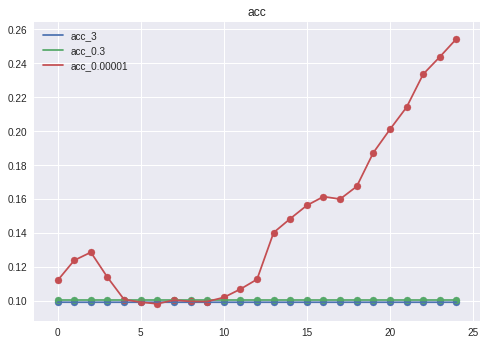

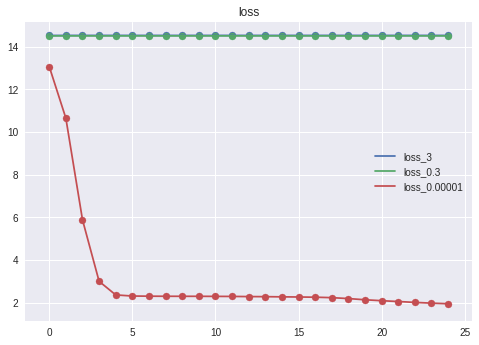

In [0]:
# Use plotHistory to make these plots
names = ['3', '0.3', '0.00001']
plotHistory(learning_rate_hist, names, 'acc')
plotHistory(learning_rate_hist, names, 'loss')

Analysis: We can see that both, 3 and 0.3 are too high for learning rates. This is leading to the steps being too large and hence the weights are being changed very drastically, with no convergance happening. When choosing a learning rate of 0.00001, we see a lot of improvement, but this is only relative. The maximum accuracy reached was around 26%, perhaps if the network was trained for more epochs (~100), we would see the accuracy rise to a respectable amount but currently it is too small to make a significant impact. perhaps if we tested with a more diverse range i.e including 0.01, 0.001 and 0.0001, then we could see a trend for the best performing LR.